In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import pylab
import calendar
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)
%matplotlib inline

In [3]:
dataTrain = pd.read_csv("../Deploying Bike sharing model/bike-sharing-demand/train.csv")
dataTest = pd.read_csv("../Deploying Bike sharing model/bike-sharing-demand/test.csv")

In [4]:
#combine test and train data
data = dataTrain.append(dataTest)
data.reset_index(inplace = True)
data.drop('index', inplace = True, axis = 1)

In [5]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
dataWindspeedOriginal = data["windspeed"]

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'windspeed Values'),
 Text(0.5, 1.0, 'Count of windspeed values before imputing')]

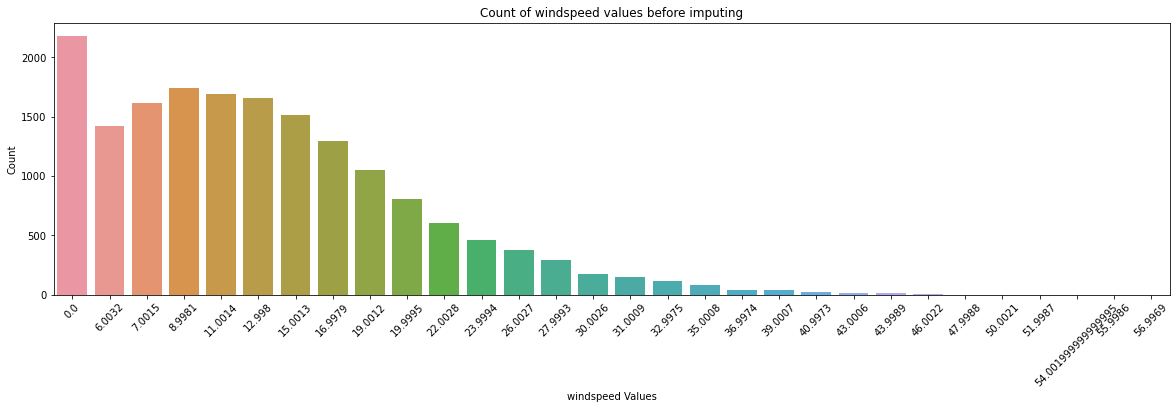

In [6]:
fig,ax= plt.subplots(nrows=1)
fig.set_size_inches(20,5)
#sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
#hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='windspeed Values', ylabel='Count',title="Count of windspeed values before imputing")

In [7]:
from sklearn.ensemble import RandomForestClassifier
wCol= ["season","weather","humidity","month","temp","year","atemp"]
#dataWind0 is the entire dataset(contains cols season, weather, humidity, month, temp, year, atemp)
#with windspeed value = 0
dataWind0 = data[data["windspeed"] == 0]
#dataNotWind0 is the entire dataset(contains cols season, weather, humidity, month, temp, year, atemp)
#without windspeed value = 0
dataWindNot0 = data[data["windspeed"] != 0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

#predicting value for windspeed = 0
rfModel_wind = RandomForestClassifier()
rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
Wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

dataWind0["windspeed"] = Wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)



[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Windspeed Values'),
 Text(0.5, 1.0, 'Count Of Windspeed Values After Imputing'),
 None]

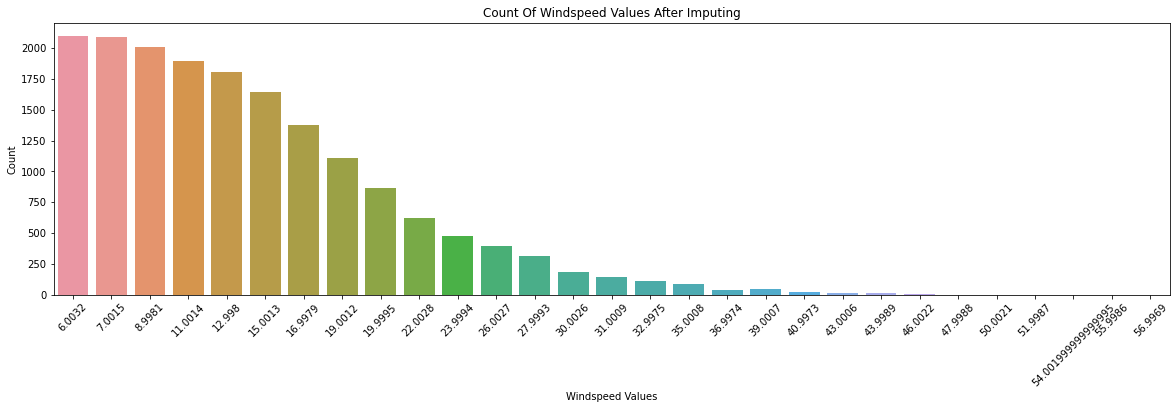

In [8]:
fig, ax =plt.subplots(nrows=1)
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

In [9]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [10]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [11]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])#datatime is not droppe, month, week etc are created from it.
dataTest = data[~pd.notnull(data['count'])].sort_values(by = ["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsRegistered = dataTrain["registered"]
yLabelsCasual = dataTrain["casual"]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( dataTrain, yLabels, test_size=0.3, random_state=42)
dateTimeColValidate = X_validate["datetime"]

In [13]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

In [14]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [15]:
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.19532851612926086


Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.

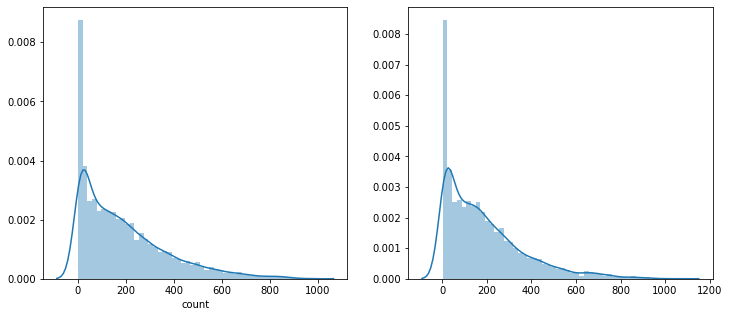

In [17]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)


In [18]:
import pickle
# Save the trained model as a pickle file. 
#with open('bike_sharing-demand-model.pkl', 'wb') as file:
    #pickle.dump(rfModel, file)
# Save the trained model as a pickle string. 
pickle.dump(gbm, open('bike_sharing-demand-model.pkl', 'wb'))

In [19]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)